In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit

In [2]:
df = pd.read_csv("../../data/processed/kicks26.01.2017.csv")
df = df.drop(df[df['duration'] < 0.01].index) # Quickly drop weird kicks.
#df = df.sample(frac=0.1, random_state=np.random.RandomState(42)) # First work with a fraction of data
df.index = np.arange(0, len(df))
df.describe()

,heading_change,duration,length,max_vel,neighbor_distance,neighbor_angle,viewing_angle_ltf,viewing_angle_ftl,rel_orientation,wall_distance_f0,wall_angle_f0,wall_distance_f1,wall_angle_f1
count,29561.000000,29561.000000,29561.000000,29561.000000,29561.000000,29561.000000,29561.000000,29561.000000,29561.000000,29561.000000,29561.000000,29561.000000,29561.000000
mean,-0.066669,0.472611,0.878033,3.854405,8.975708,0.014480,-0.206967,-0.158974,0.160159,3.909949,-0.994393,3.963407,-0.990521
std,0.656192,0.158527,0.485867,1.447508,6.832681,1.828429,2.210177,1.277022,1.523186,2.821973,1.464453,2.838830,1.501769
min,-3.133960,0.019161,0.000418,0.463552,0.229027,-3.140932,-3.141529,-3.104660,-3.141510,0.009104,-3.141475,0.015685,-3.140862
25%,-0.394296,0.364052,0.512356,2.853653,2.927745,-1.535121,-2.267124,-1.134067,-0.773413,1.494145,-1.860386,1.540903,-1.892599
50%,-0.051024,0.431115,0.850953,3.877972,6.764342,-0.035883,-1.085294,-0.239530,0.198001,3.510908,-1.486718,3.577114,-1.502867
75%,0.240809,0.546078,1.169651,4.752432,14.329340,1.637108,2.121685,0.796077,1.225442,5.696184,-0.731896,5.754911,-0.683513
max,3.136400,1.619075,8.213735,14.221034,27.324529,3.141113,3.141590,3.125924,3.141578,13.947776,3.141431,13.872844,3.140876


In [3]:
heading_change = df['heading_change'].values
wall_distance = df['wall_distance_f0'].values
wall_angle = df['wall_angle_f0'].values

# Discretize into I x J boxes
I = 40 # 40
J = 30 # 30
WALL_RADIUS = 14
boxlim_f = np.linspace(0, WALL_RADIUS, I)
boxlim_O = np.linspace(-np.pi, np.pi, J)

f = np.zeros(I )# 0... radius=14
O = np.zeros(J) # -pi ... pi



In [4]:
boxcount = np.zeros((I,J)) # dirty hack
boxheading = np.zeros((I,J))
for i in range(0, len(wall_distance)):
    box_f = np.digitize(wall_distance[i], boxlim_f, right=False)
    box_O = np.digitize(wall_angle[i], boxlim_O, right=False)
    boxcount[box_f, box_O] += 1
    boxheading[box_f, box_O] += heading_change[i]
    
    # Add inverse angle as well
    box_f = np.digitize(wall_distance[i], boxlim_f, right=False)
    box_O = np.digitize(-wall_angle[i], boxlim_O, right=False)
    boxcount[box_f, box_O] += 1
    boxheading[box_f, box_O] += -heading_change[i]
    
# No entry in box -> average heading is zero!
with np.errstate(divide='ignore'):
    boxheading = np.divide(boxheading, boxcount)
boxheading[np.isnan(boxheading)] = 0


/home/lukas/bin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


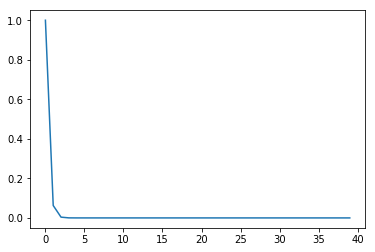

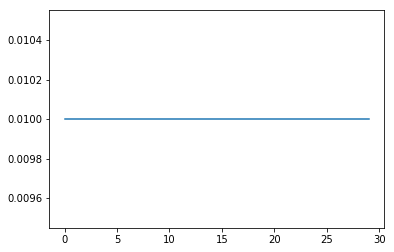

In [42]:
# Init f and O with 'reasonable' values
f = np.exp(-(boxlim_f/(0.36)**2))
#f = np.zeros(boxlim_f.shape) + 0.5
#O = np.sin(boxlim_O)# odd function
O = np.zeros(boxlim_O.shape) + 0.01
plt.plot(range(I), f)
plt.figure()
plt.plot(range(0,J), O)

In [43]:
# Fitting
def step(f, O):

    damping = 0.25
    for i in range(0, I):
        newF = np.sum(boxcount[i] * boxheading[i] * O) / np.sum(boxcount[i] * O**2)
        if np.isnan(newF):
            #print(i)
            newF = f[i]
        #print(newF)
        f[i] = (1 - damping) * f[i] + damping * newF
    
    for j in range(0, J):
        newO = np.sum(boxcount[:,j] * boxheading[:,j] * f) / np.sum(boxcount[:,j] * f**2)
        if np.isnan(newO):
            #print(j)
            newO = O[j]
        O[j] = (1 - damping) * O[j] + damping * newO
        
    # Normalize J s.t. its average square is one
    norm = np.sum(np.square(O)) * J
    O = (O / norm)
    f = f * norm
    #f /= J
   # O *= J
    return f, O

/home/lukas/bin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/home/lukas/bin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


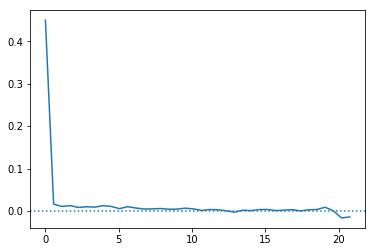

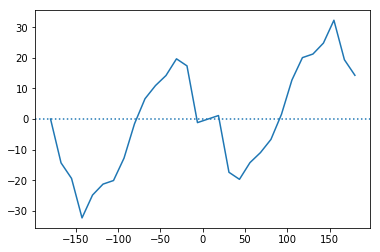

In [46]:
for i in range(0, 100):
    f, O = step(f, O)
plt.plot(boxlim_f[0:I-2]/0.64, f[0:I-2])
plt.axhline(0, linestyle='dotted')
plt.figure()
plt.plot(np.rad2deg(boxlim_O[0:]), O[0:])
#plt.plot(np.rad2deg(boxlim_O), np.sin(1 + 0.7 * np.cos(2 * boxlim_O)))
plt.axhline(0, linestyle='dotted')

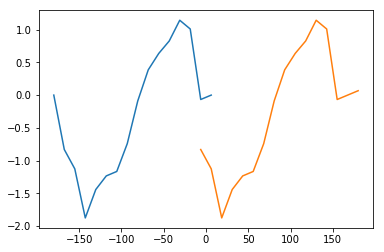

In [36]:
plt.plot(np.rad2deg(boxlim_O[0:16]), O[0:16])
plt.plot(np.rad2deg(boxlim_O[14:30]), -O[::-1][0:16])

In [31]:
O[::-1][0:15]

array([  8.30968407e-01,   1.12615098e+00,   1.87581732e+00,
         1.44225402e+00,   1.23440976e+00,   1.16619950e+00,
         7.41594476e-01,   8.89294743e-02,  -3.85930813e-01,
        -6.36325595e-01,  -8.26878984e-01,  -1.14341285e+00,
        -1.00984112e+00,   6.70644584e-02,   1.51690659e-39])

In [28]:
O[0:10]*1.0

array([ -5.20821110e-17,  -8.30968407e-01,  -1.12615098e+00,
        -1.87581732e+00,  -1.44225402e+00,  -1.23440976e+00,
        -1.16619950e+00,  -7.41594476e-01,  -8.89294743e-02,
         3.85930813e-01])